<a href="https://colab.research.google.com/github/wwang2/Coarse-Graining-Auto-encoders/blob/master/cgae_alanine_dipeptide_colab_walkthrough.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


In this notbook you will use a Coarse-Grained Autoencoder applied on Alanine Dipeptide Trajectores. The code is SUPER simple. 

First you will need to install some packages. This might take a few miniutes. 

In [1]:
! pip install nglview
! pip install ase
! pip install mdtraj
! pip install mdshare

In [2]:
import torch
from torch import nn
import numpy as np
import mdshare 
import mdtraj as md 
import glob
import torch.nn.functional as F
from ase import Atoms
from nglview import show_ase
import matplotlib.pyplot as plt

# this is needed is you want to use nglview to visualize reconstructed coordinates 
from google.colab import output
output.enable_custom_widget_manager()

In [4]:
# load alanine dipeptide trajectory 
mdshare.fetch('alanine-dipeptide-nowater.pdb', working_directory='data')
mdshare.fetch('alanine-dipeptide-*-250ns-nowater.xtc', working_directory='data')

xtc_files = glob.glob('./data/alanine-dipeptide-*-250ns-nowater.xtc')
traj = [md.load_xtc(file, top='./data/alanine-dipeptide-nowater.pdb') for file in xtc_files]

traintraj = md.join(traj[:-1])
testtraj = traj[-1]

In [7]:
# retrieve bond info 
g = traintraj.topology.to_bondgraph()
bond_idx = torch.LongTensor( [[pair[0].index, pair[1].index] for pair in  g.edges] )
# todo: add two-hop bond list 

In [8]:
# build dataset and dataloader 
train_xyz = torch.Tensor( traintraj.xyz[::1000]) * 10.0 # take 500 data points 
test_xyz = torch.Tensor( testtraj.xyz[::1000])* 10.0

trainset = torch.utils.data.TensorDataset(train_xyz)
testset = torch.utils.data.TensorDataset(test_xyz)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=True)

In [9]:
# define a CGAE

class cgae(nn.Module):
    
    def __init__(self, n_atoms, n_cgs):
        super().__init__()

        assign_map = torch.randn(n_atoms, n_cgs)
        decode = torch.randn(n_cgs, n_atoms)
        
        
        self.n_atoms = n_atoms 
        self.assign_map = nn.Parameter(assign_map)
        self.decode = nn.Parameter(decode)
        
    def forward(self, xyz, tau=1.0):
        
        # recenter coordinates 
        xyz = xyz.reshape(-1, self.n_atoms, 3)
        shift = xyz.mean(1)
        xyz = xyz - shift.unsqueeze(1)
        
        # get discrete assignment map
        M = F.gumbel_softmax(self.assign_map, dim=-1)
        M_norm = M / M.sum(-2).unsqueeze(-2)
        
        cg_xyz = torch.einsum('bij,in->bnj', xyz, M_norm)
        xyz_recon = torch.einsum('bnj,ni->bij', cg_xyz, self.decode)
        
        return xyz, xyz_recon, M, cg_xyz

In [10]:

# Define the latent CG dimension, feel free to set your own, it only needs to be smaller than the number of total atoms 

device = "cpu" # device cardinal
N_cg = 6 # play with this by yourself. 
ae = cgae(train_xyz.shape[1], N_cg).to(device)

optimizer = torch.optim.Adam(list(ae.parameters()), lr=4e-3)

In [21]:
# training loop
tau = 1.0

for epoch in range(600):
    all_bond_loss = []
    all_loss = []
    all_reg = []
    all_recon = [] 
    for i, xyz in enumerate(trainloader):
        
        # recenter xyz 
        xyz = xyz[0].to(device)

        # encode and decode coordinates 
        xyz, xyz_recon, M, cg_xyz = ae(xyz, tau)
        
        # lift the cg_xyz back to the FG space 
        X_lift = torch.einsum('bij,ni->bnj', cg_xyz, M)
        
        # compute regularization to penalize atoms that are assigned too far away 
        loss_reg = (xyz - X_lift).pow(2).sum(-1).mean()
        
        # comput reconstruction 
        loss_recon = (xyz - xyz_recon).pow(2).mean() 

        # compute bond loss 
        bond_true = (xyz[:, bond_idx[:,0]] - xyz[:, bond_idx[:,1]] + 1e-9).pow(2).sum(-1).sqrt()
        bond_prd = (xyz_recon[:, bond_idx[:,0]] - xyz_recon[:, bond_idx[:,1]]+ 1e-9).pow(2).sum(-1).sqrt()
        loss_bond = (bond_true - bond_prd).pow(2).mean()

        # total loss 
        loss = loss_recon + 0.5 * loss_reg + loss_bond
        
        all_bond_loss.append(loss_bond.item())
        all_reg.append(loss_reg.item())
        all_recon.append(loss_recon.item())
        all_loss.append(loss.item())
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        all_loss.append(loss.item())

    # temperature scheduler for gubmel softmax     
    if tau >= 0.1:
        tau -= 0.001
    if epoch == 0:
      print("epoch", "tau", "reconstruction", "regularization loss", "bond loss")
    print(epoch, tau, np.array(all_recon).mean(), np.array(all_reg).mean(), np.array(all_bond_loss).mean())

epoch tau reconstruction regularization loss bond loss
0 0.999 0.18794269394129515 0.9494620151817799 0.07071357336826622
1 0.998 0.18811730481684208 0.9817295782268047 0.026141098176594824
2 0.997 0.18896980211138725 0.954344879835844 0.021235478518065065
3 0.996 0.18892700597643852 0.9527863301336765 0.018947689910419285
4 0.995 0.194182219915092 0.9595500603318214 0.019894570985343307
5 0.994 0.18457209505140781 0.9404403641819954 0.01856724766548723
6 0.993 0.18768739141523838 0.9389437176287174 0.01599408150650561
7 0.992 0.18830496538430452 0.9625677540898323 0.01757922157412395
8 0.991 0.18488283921033144 0.948576919734478 0.016158708254806697
9 0.99 0.18753150664269924 0.9580348581075668 0.016312761435983703
10 0.989 0.18356991466134787 0.9267603158950806 0.014432864089030772
11 0.988 0.18901760503649712 0.9484840892255306 0.017517592234071344
12 0.987 0.18322263844311237 0.9110588319599628 0.0147134093567729
13 0.986 0.18848702311515808 0.9517478495836258 0.01658239704556763
1

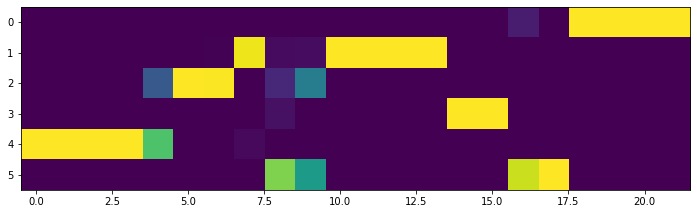

In [22]:
# visualize the learned CG assignment 
plt.figure(figsize=(12,20))
plt.imshow(M.t().detach().cpu().numpy())
plt.show()

In [22]:
# visualze reconstructed alanine dipeptide 
atomic_nums = [atom.element.atomic_number for atom in traintraj.top.atoms] 
reconstructed_xyz = xyz_recon[0].detach().cpu().numpy()
recon_alaine_dipep = Atoms(positions= reconstructed_xyz, numbers=atomic_nums)
show_ase(recon_alaine_dipep)

NGLWidget()

In [23]:
# visualze reconstructed alanine dipeptide 
atomic_nums = [atom.element.atomic_number for atom in traintraj.top.atoms] 
reconstructed_xyz = xyz_recon[0].detach().cpu().numpy()
recon_alaine_dipep = Atoms(positions= reconstructed_xyz, numbers=atomic_nums)
show_ase(recon_alaine_dipep)

NGLWidget()

In [24]:
# visualze reconstructed alanine dipeptide 
atomic_nums = [atom.element.atomic_number for atom in traintraj.top.atoms] 
reconstructed_xyz = xyz[0].detach().cpu().numpy()
recon_alaine_dipep = Atoms(positions= reconstructed_xyz, numbers=atomic_nums)
show_ase(recon_alaine_dipep)

NGLWidget()

In [27]:
# visualize Coarse-Grained alanine dipeptide
cg_nums = [1] * N_cg
cg_alaine_dipep = Atoms(positions= cg_xyz[0].detach().cpu().numpy(), numbers=cg_nums)
show_ase(cg_alaine_dipep)

NGLWidget()